In [44]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from scipy import stats
from scipy.stats import randint 
from scipy.stats import uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

In [45]:
# import data
dataset_og = pd.read_csv('Data\Measurements-Transformed')
# kopie maken indien we iets van de originele data nodig hebben
dataset = dataset_og.copy()
dataset.head(5)

,Unnamed: 0,ID,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
0,0,516642.0,0.0,57.0,0.0,-1.75,0.50,55.0,-2.25,1.0,55.0,-1.75,1.00,110.0,-1.25,0.5,110.0
1,1,516642.0,0.0,55.0,0.0,-1.75,0.50,65.0,0.00,0.0,0.0,-1.25,0.50,110.0,0.00,0.0,0.0
2,2,516642.0,0.0,49.0,0.0,-1.50,0.50,65.0,0.00,0.0,0.0,-1.00,0.50,110.0,0.00,0.0,0.0
3,3,840697.0,1.0,37.0,0.0,-3.50,1.50,180.0,-3.50,1.5,180.0,-3.00,1.50,180.0,-3.00,1.5,180.0
4,4,840697.0,1.0,26.0,0.0,-2.00,0.75,175.0,0.00,0.0,0.0,-2.00,0.75,180.0,0.00,0.0,0.0


In [46]:
dataset = dataset.drop(columns=['Unnamed: 0'])

In [49]:
dataset.dtypes

ID                 category
Sex                 float64
Measurement_Age     float64
Add                 float64
Sph-Far-R           float64
Cyl-Far-R           float64
Axis-Far-R          float64
Sph-Close-R         float64
Cyl-Close-R         float64
Axis-Close-R        float64
Sph-Far-L           float64
Cyl-Far-L           float64
Axis-Far-L          float64
Sph-Close-L         float64
Cyl-Close-L         float64
Axis-Close-L        float64
dtype: object

In [48]:
dataset['ID'] = dataset['ID'].astype('category')

In [9]:
df = dataset[dataset['ID'] == 576788.0]
df.head(10)

,ID,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
42823,576788.0,0.0,53.0,1.75,2.25,0.50,5.0,4.00,0.50,5.0,2.0,0.50,170.0,3.75,0.5,170.0
42824,576788.0,0.0,52.0,0.00,0.00,0.00,0.0,4.75,0.50,5.0,0.0,0.00,0.0,4.50,0.5,170.0
42825,576788.0,0.0,52.0,0.00,2.25,0.50,5.0,0.00,0.00,0.0,2.0,0.50,170.0,0.00,0.0,0.0
42826,576788.0,0.0,51.0,2.00,3.00,0.50,5.0,4.75,0.75,5.0,2.5,0.75,155.0,4.75,0.5,155.0
42827,576788.0,0.0,50.0,0.00,2.25,0.50,10.0,0.00,0.00,0.0,2.0,0.50,170.0,0.00,0.0,0.0
42828,576788.0,0.0,49.0,0.00,0.00,0.00,0.0,4.00,0.50,10.0,0.0,0.00,0.0,3.75,0.5,170.0
42829,576788.0,0.0,49.0,0.00,2.25,0.50,10.0,0.00,0.00,0.0,2.0,0.50,170.0,0.00,0.0,0.0
42830,576788.0,0.0,47.0,0.00,1.50,0.75,10.0,0.00,0.00,0.0,1.5,0.50,170.0,0.00,0.0,0.0
42831,576788.0,0.0,46.0,0.00,1.25,0.50,0.0,0.00,0.00,0.0,1.0,0.50,0.0,0.00,0.0,0.0
42832,576788.0,0.0,46.0,0.00,0.00,0.00,0.0,3.00,0.50,0.0,0.0,0.00,0.0,2.75,0.5,0.0


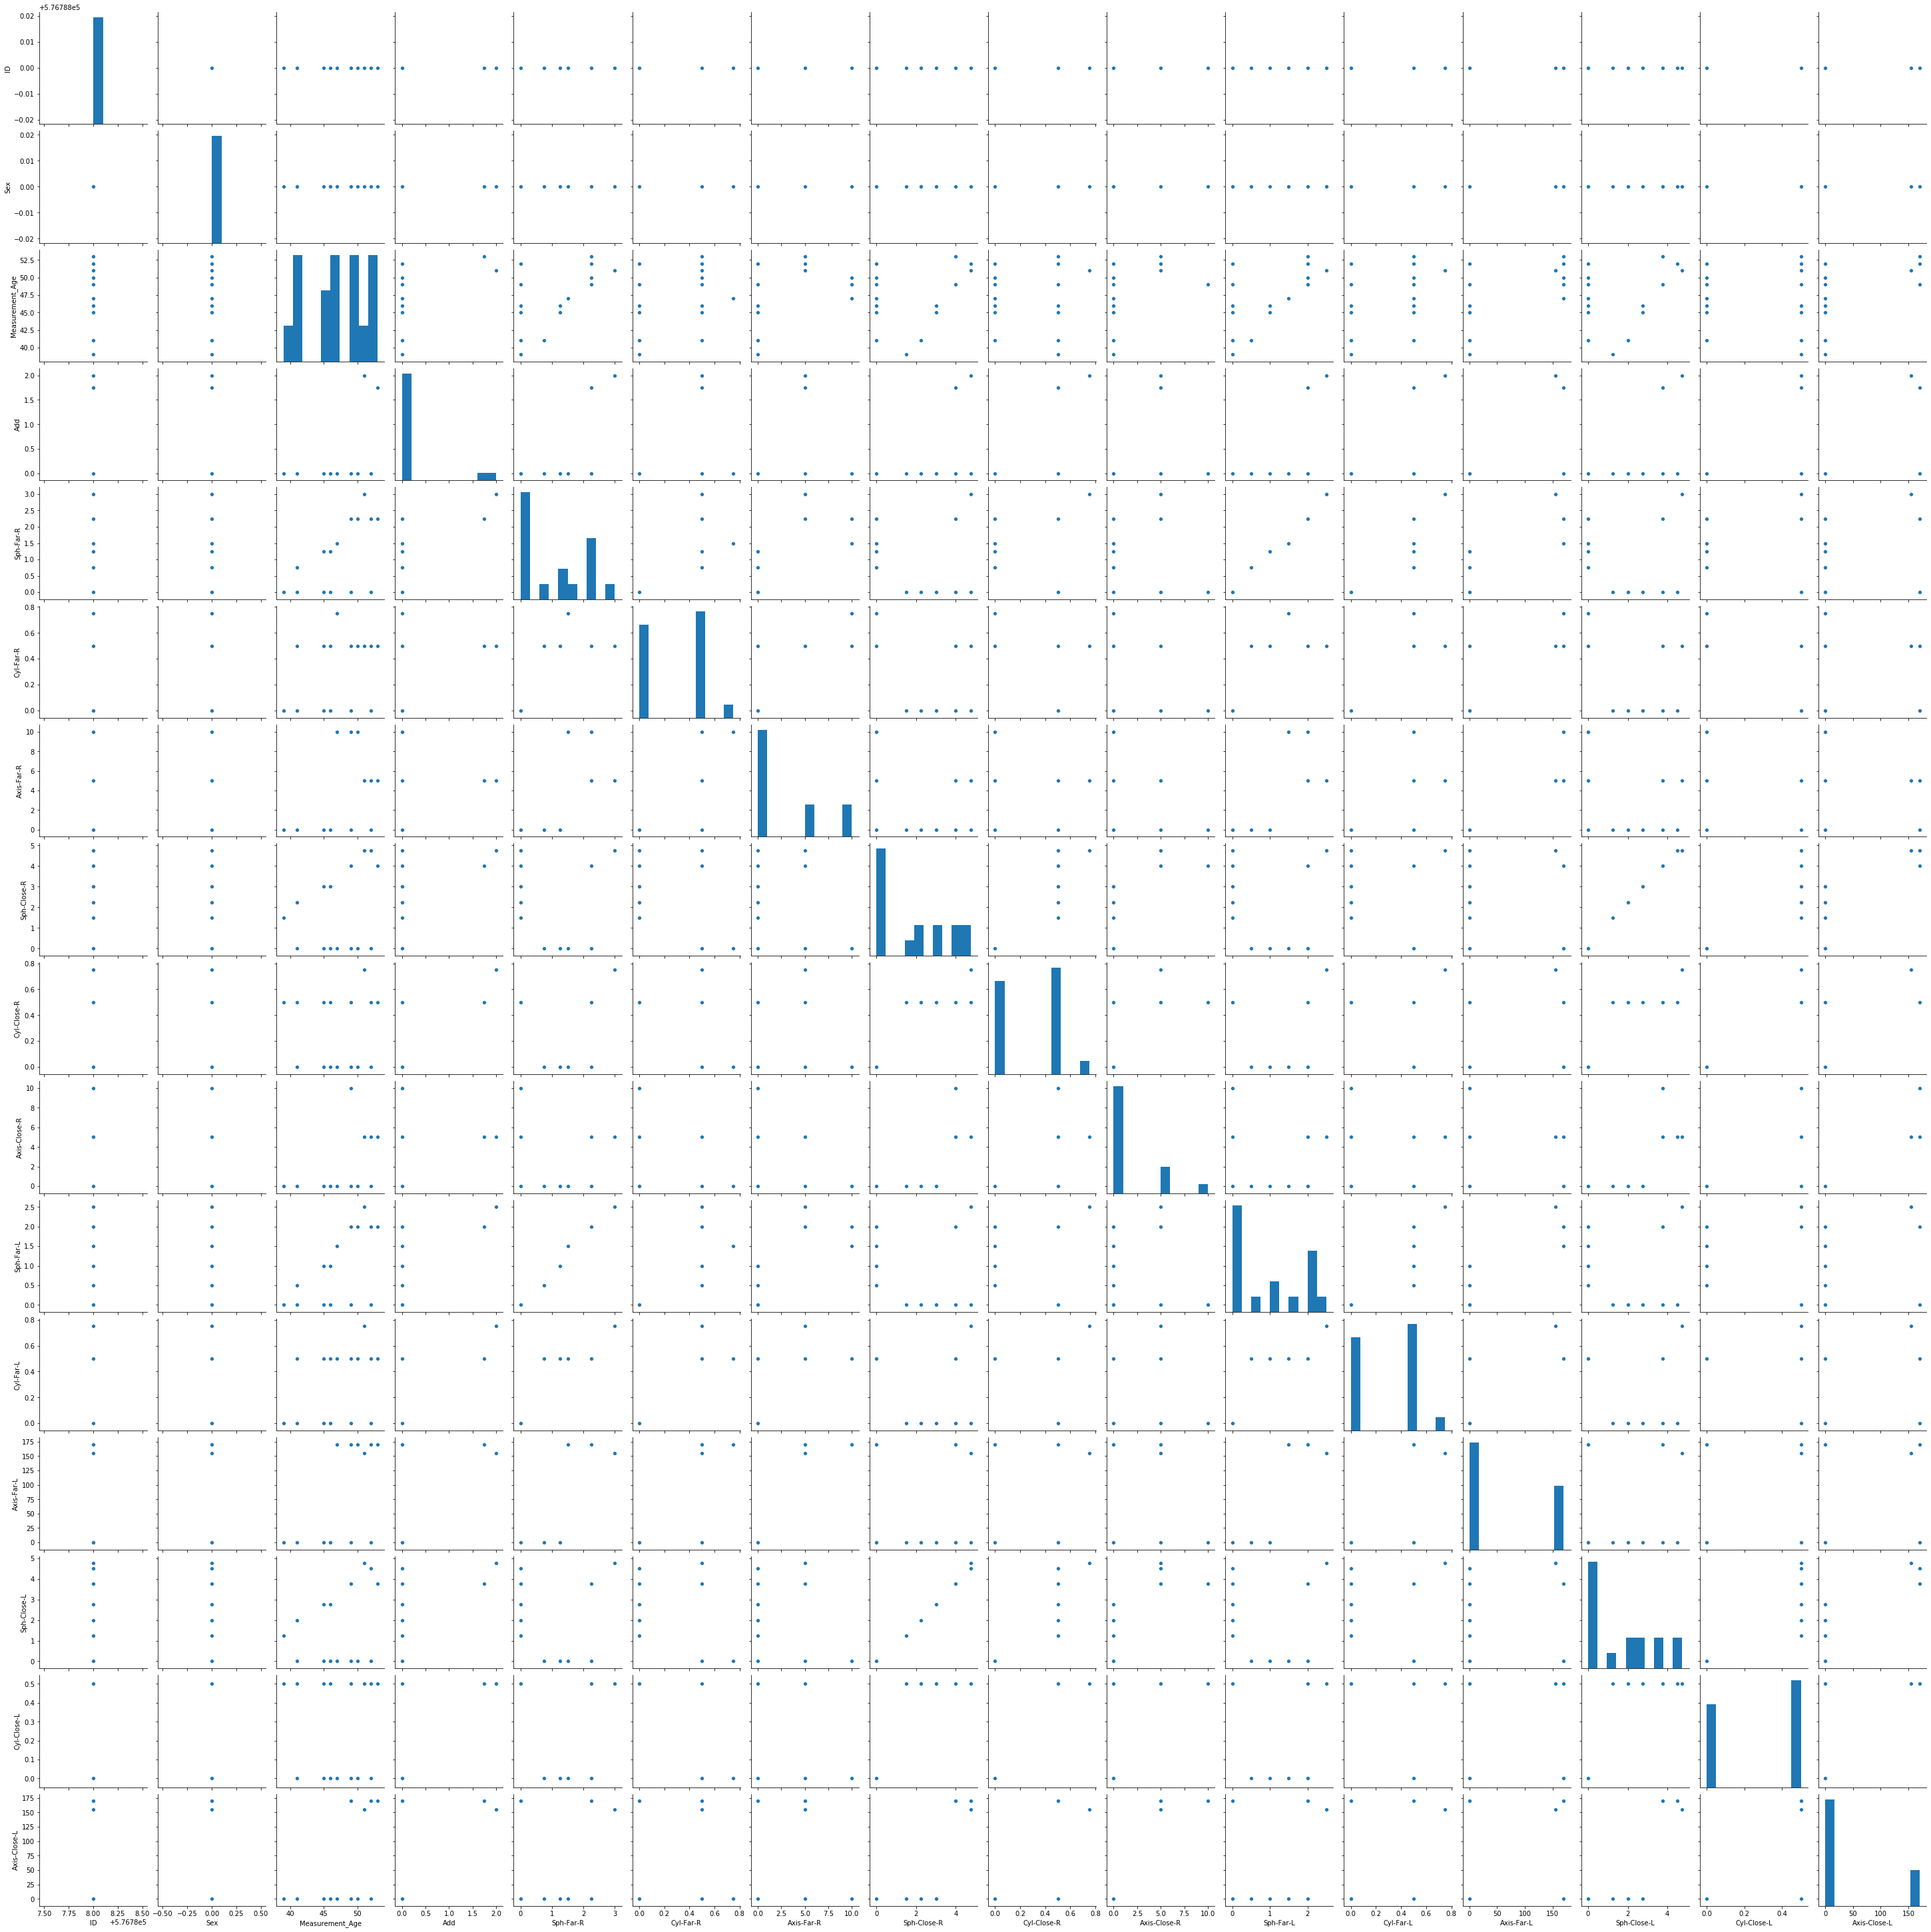

In [10]:
sns.pairplot(df)

In [26]:
# Splitsen in features en targets

y = dataset['Sph-Far-R'].values
X = dataset.drop('Sph-Far-R',axis=1)

In [27]:
# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000, random_state=0)

In [28]:
# Linear regression

regmodel = linear_model.LinearRegression()
regmodel.fit(X_train,y_train)
print(regmodel.coef_)
r2 = regmodel.score(X_test,y_test)
print('r2 score = ', r2)

[ 5.87084376e-08 -5.48781115e-03  7.07665520e-04 -5.80646310e-03
 -6.87020885e-01  8.95292392e-06  5.69731819e-01  4.99535945e-01
  1.55048334e-04  9.16480388e-01  6.93490112e-01  3.71711435e-04
 -5.07571630e-01 -4.96646363e-01 -5.49091263e-04]
r2 score =  0.9168816329160875


In [22]:
# Sliding window

X_window = []
y_window = []


window_size = 2

for w in range(window_size,X.shape[0]):
    
    X_window.append(X[w-window_size:w,:].reshape(1,-1))
    y_window.append(y[w-1])

X_window = np.asarray(X_window)
X_window = np.squeeze(X_window,axis=1)
y_window = np.asarray(y_window)

TypeError: '(slice(0, 1, None), slice(None, None, None))' is an invalid key